In [1]:
import matplotlib.pyplot as plt

In [2]:
from datasets import load_dataset

# Load a dataset
dataset = load_dataset('b-mc2/sql-create-context')

In [3]:
contexts = [example['context'] for example in dataset['train']]
answers = [example['answer'] for example in dataset['train']]
questions = [example['question'] for example in dataset['train']]

In [4]:
from sklearn.model_selection import train_test_split

# Assuming contexts, answers, and questions are your dataset
data = list(zip(contexts, answers, questions))

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Unzip the data
train_contexts, train_answers, train_questions = map(list, zip(*train_data))
val_contexts, val_answers, val_questions = map(list, zip(*val_data))

In [5]:
import re

def prepare_text(text):
    text = '<START>' + text + '<END>'
    return text

train_answers = list(map(prepare_text, train_answers))

In [6]:
from tokenizers import Tokenizer, trainers, models, pre_tokenizers, decoders, processors
import tensorflow as tf

# Initialize a tokenizer
tokenizer = Tokenizer(models.BPE())

# Set padding token. Padding token must be zero.
tokenizer.add_special_tokens(["<PAD>", "<START>", "<END>"])
tokenizer.enable_padding(pad_id=0, pad_token="<PAD>")

# Gather all texts
all_texts = train_contexts + train_questions + train_answers

# Train the tokenizer
tokenizer.train_from_iterator(all_texts)

# Now you can use the tokenizer to encode your texts
prompt_tokens, answer_tokens = [], []
for context, question, answer in zip(train_contexts, train_questions, train_answers):
    prompt = question + " context: " + context
    prompt_tokens.append(tokenizer.encode(prompt).ids)
    answer_tokens.append(tokenizer.encode(answer).ids)

In [7]:
tokenizer.encode("<END>").ids

[2]

(array([3.9433e+04, 1.9802e+04, 3.1700e+03, 3.7200e+02, 6.8000e+01,
        1.1000e+01, 0.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  7. ,  19.4,  31.8,  44.2,  56.6,  69. ,  81.4,  93.8, 106.2,
        118.6, 131. ]),
 <BarContainer object of 10 artists>)

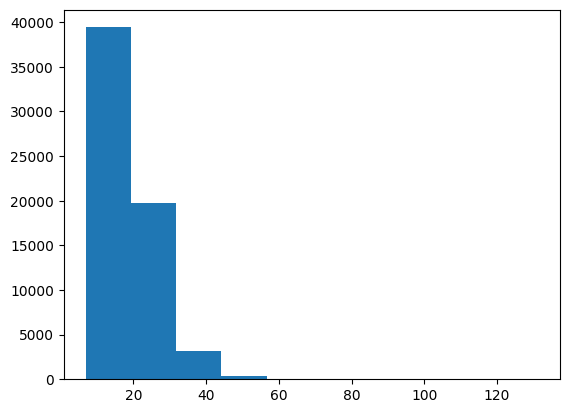

In [8]:
seq_lengths = [len(seq) for seq in prompt_tokens]
plt.hist(seq_lengths)

In [9]:
prompt_seq_length = 50  # replace with your desired sequence length
answer_seq_length = 50

# Add padding if necessary
prompt_tokens_padded = tf.keras.preprocessing.sequence.pad_sequences(prompt_tokens, maxlen=prompt_seq_length, padding='post', value=0)
answer_tokens_padded = tf.keras.preprocessing.sequence.pad_sequences(answer_tokens, maxlen=answer_seq_length, padding='post', value=0)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights


In [10]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % self.num_heads == 0

        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output


@tf.keras.saving.register_keras_serializable()
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(feedforward_dim, activation="relu"), tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


from tensorflow.keras.layers import LayerNormalization

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super(FeedForward, self).__init__()
        self.fc1 = tf.keras.layers.Dense(dff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out


@tf.keras.saving.register_keras_serializable()
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, feedforward_dim):
        super(TransformerDecoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.feedforward_dim = feedforward_dim

        self.multi_head_attention1 = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim)
        self.multi_head_attention2 = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim)
        self.feed_forward = FeedForward(self.embedding_dim, self.feedforward_dim)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
    
    def create_lookahead_mask(self, tensor):
        # Get the sequence length from the tensor shape
        seq_length = tf.shape(tensor)[1]
    
        # Create a lookahead mask
        mask = 1 - tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
    
        # Expand dimensions to match batch size
        mask = tf.expand_dims(mask, 0)  
    
        # Tile mask to match batch size
        mask = tf.tile(mask, [tf.shape(tensor)[0], 1, 1])
    
        # Convert to boolean
        mask = tf.cast(mask, dtype=tf.bool)
    
        return mask

    def call(self, decoder_embeddings, encoder_output):
        #lookahead_mask = self.create_lookahead_mask(decoder_embeddings)
        attention_output1 = self.multi_head_attention1(decoder_embeddings, decoder_embeddings, decoder_embeddings, use_causal_mask = True)
        attention_output1 = self.layernorm1(attention_output1 + decoder_embeddings)
        attention_output2 = self.multi_head_attention2(attention_output1, encoder_output, encoder_output)
        attention_output2 = self.layernorm2(attention_output2 + attention_output1)
        feed_forward_output = self.feed_forward(attention_output2)
        decoder_output = self.layernorm3(feed_forward_output + attention_output2)
        return decoder_output


In [12]:
@tf.keras.saving.register_keras_serializable()
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
from keras_nlp.layers import ReversibleEmbedding, PositionEmbedding
#from keras_nlp.layers import TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

sequence_length = 50
vocab_size = tokenizer.get_vocab_size()
num_heads = 8
embedding_dim = 64
feedforward_dim = 512

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
encoder_token_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(encoder_input)
encoder_position_embeddings = PositionEmbedding(sequence_length=sequence_length)(encoder_token_embeddings)
encoder_embeddings = tf.keras.layers.Add()([encoder_token_embeddings, encoder_position_embeddings])
encoder_output = TransformerEncoder(embedding_dim, num_heads, feedforward_dim)(encoder_embeddings)

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
decoder_token_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(decoder_input)
decoder_position_embeddings = PositionEmbedding(sequence_length=sequence_length)(decoder_token_embeddings)
decoder_embeddings = tf.keras.layers.Add()([decoder_token_embeddings, decoder_position_embeddings])
decoder_output = TransformerDecoder(embedding_dim, num_heads, feedforward_dim)(decoder_embeddings, encoder_output)
#decoder_output = TransformerDecoder(feedforward_dim, num_heads)(decoder_embeddings, encoder_output)
decoder_output = Dropout(0.4)(decoder_output)

final_output = Dense(vocab_size, activation='softmax')(decoder_output)
model = Model([encoder_input, decoder_input], final_output)
model.compile(optimizer='adam', loss=masked_loss, metrics=['accuracy'])
model.summary(line_length=120)


Using TensorFlow backend


2024-05-24 11:32:14.934553: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-05-24 11:32:14.934571: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-24 11:32:14.934575: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-24 11:32:14.934600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-24 11:32:14.934612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                       Output Shape                        Param #     Connected to                        
 encoder_input (InputLayer)         [(None, None)]                      0           []                                  
                                                                                                                        
 decoder_input (InputLayer)         [(None, None)]                      0           []                                  
                                                                                                                        
 embedding (Embedding)              (None, None, 64)                    1920128     ['encoder_input[0][0]']             
                                                                                                                        
 embedding_1 (Emb

In [14]:
inputs = { 'encoder_input': prompt_tokens_padded, 'decoder_input': answer_tokens_padded[:, :-1] }
outputs = answer_tokens_padded[:, 1:]

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath = 'model/sql_qa_model.keras'
callback_es = EarlyStopping(monitor='val_accuracy', restore_best_weights=True)
callback_mc = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(inputs, outputs, epochs=40, validation_split=0.2, callbacks=[callback_es, callback_mc])

Epoch 1/40


2024-05-24 11:32:22.699057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1572/1572 [==============================] - ETA: 0s - loss: 5.9098 - accuracy: 0.0711
Epoch 1: val_accuracy improved from -inf to 0.08014, saving model to model/sql_qa_model.keras
1572/1572 [==============================] - 171s 108ms/step - loss: 5.9098 - accuracy: 0.0711 - val_loss: 4.9503 - val_accuracy: 0.0801
Epoch 2/40
1572/1572 [==============================] - ETA: 0s - loss: 4.5741 - accuracy: 0.0873
Epoch 2: val_accuracy improved from 0.08014 to 0.09759, saving model to model/sql_qa_model.keras
1572/1572 [==============================] - 167s 106ms/step - loss: 4.5741 - accuracy: 0.0873 - val_loss: 4.1215 - val_accuracy: 0.0976
Epoch 3/40
1572/1572 [==============================] - ETA: 0s - loss: 3.8037 - accuracy: 0.1063
Epoch 3: val_accuracy improved from 0.09759 to 0.12155, saving model to model/sql_qa_model.keras
1572/1572 [==============================] - 170s 108ms/step - loss: 3.8037 - accuracy: 0.1063 - val_loss: 3.4456 - val_accuracy: 0.1215
Epoch 4/40
1572/15

In [16]:
model = tf.keras.models.load_model("model/sql_qa_model.keras")

In [22]:
def get_bot_answer(text, model, tokenizer, sequence_length):

    text_encoded = tokenizer.encode(text)
    encoder_input = text_encoded.ids
    encoder_input = tf.keras.preprocessing.sequence.pad_sequences([encoder_input], maxlen=sequence_length, padding='post', value=0)
    encoder_input = tf.convert_to_tensor(encoder_input)
    encoder_input = tf.reshape(encoder_input, (1, 50))
    
    decoded_text = '<START>'
    for i in range(sequence_length):
        decoder_input = tokenizer.encode(decoded_text).ids
        decoder_input = tf.keras.preprocessing.sequence.pad_sequences([decoder_input], maxlen=sequence_length, padding='post', value=0)
        decoder_input = tf.convert_to_tensor(decoder_input)
        decoder_input = tf.reshape(decoder_input, (1, 50))
    
        prediction = model([encoder_input, decoder_input])
    
        idx = np.argmax(prediction[0, i, :])
        token = tokenizer.decode([idx])
        decoded_text += token

        if token == '<END>':
            break

    return decoded_text


In [23]:
print (inputs['encoder_input'].shape)
print (inputs['decoder_input'].shape)
print (outputs.shape)

(62861, 50)
(62861, 49)
(62861, 49)


In [24]:
#prediction = model([inputs['encoder_input'][0:10], inputs['decoder_input'][0:10]])

In [25]:
for i in range(10):
    question = val_questions[i]
    context = val_contexts[i]
    answer = val_answers[i]
    prompt = question + " context: " + context
    print ("PROMPT:", prompt)
    decoded_text = get_bot_answer(prompt, model, tokenizer, sequence_length)
    print ("BOT:", decoded_text)
    print ("GroundTruth:", answer)
    print ("-------------")
    

PROMPT: What was the number of Laps with a Grid of more than 3 and Time of 39:24.967? context: CREATE TABLE table_name_8 (laps INTEGER, grid VARCHAR, time VARCHAR)
BOT: <START>SELECT"""" AND  = """"""""""""ooo" = " FROM table_name_2 WHERE oso_s_oshomosioio4 WHERE  FROM table_name_8 WHERE oolaps) FROM table_name_o"oround FROM table_name_points) FROM table_name_"" AND points > ": AND team = ""league) FROM table_name_
GroundTruth: SELECT MIN(laps) FROM table_name_8 WHERE grid > 3 AND time = "39:24.967"
-------------
PROMPT: Which Senior status has a Chief Judge of —, a Reason for termination of death, and Active service of 1967–1983? context: CREATE TABLE table_name_18 (senior_status VARCHAR, active_service VARCHAR, chief_judge VARCHAR, reason_for_termination VARCHAR)
BOT: <START>SELECT senior_status FROM table_name_18 WHERE active_known_for_termination = "—" AND reason_for_termination = "yes" AND body93633"""""""""""""ananoentdat"anent––"ml
GroundTruth: SELECT senior_status FROM table_na